## Imports

In [168]:
from os import walk 
from os.path import join
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup 

from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

import gensim
import matplotlib.pyplot as plt
import seaborn as sns

## File Paths

In [169]:
SPAM_1_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/spam_2'
HAM_1_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/ham_1'
HAM_2_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/ham_2'

NEW_SPAM_1_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/new_spam_1'
NEW_SPAM_2_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/new_spam_2'
NEW_HAM_1_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/new_ham_1'
NEW_HAM_2_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/new_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'UniversityProject_SpamFilter/01_Processing/Email_Text_Data.json'
VALIDATION_FILEPATH = 'UniversityProject_SpamFilter/validation_emails.json'
VALIDATION_DATA = 'UniversityProject_SpamFilter/Validation_Data.csv '

## Clean the Messages & Filter out Stop Words

In [170]:
def email_body_generator(path): 
                                    #walk provides a tuple 
    for root, dirnames, filenames, in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            is_body= False
            lines = []
            
            #extracts email body 
            for line in stream: 
                if is_body: 
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            #loops over the file in the directory and returns the file name and associated email body 
            yield file_name, email_body

In [171]:
def dataframe_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name) 
    
    return pd.DataFrame(rows, index=row_names) 

In [172]:
spam_emails = dataframe_from_directory(SPAM_1_FILEPATH, SPAM_CAT)
spam_emails = spam_emails.append(dataframe_from_directory(SPAM_2_FILEPATH, SPAM_CAT))
ham_emails = dataframe_from_directory(HAM_1_FILEPATH, HAM_CAT)
ham_emails = ham_emails.append(dataframe_from_directory(HAM_2_FILEPATH, HAM_CAT))

In [173]:
data = pd.concat([spam_emails, ham_emails])

In [174]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [175]:
data.drop(['cmds'], inplace = True)

In [176]:
#data.describe()

In [177]:
data['length']=data['MESSAGE'].apply(len)
data

,MESSAGE,CATEGORY,length
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,612
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1,1298
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1,6691
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,1141
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1,1795
...,...,...,...
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0,953
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0,257
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0,393
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0,1434


In [178]:
#data['length'].describe()

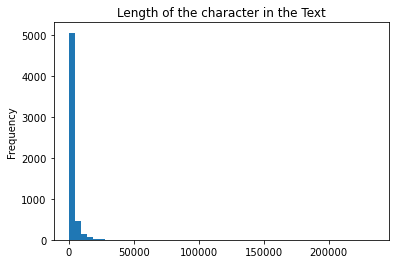

In [218]:
data['length'].plot(bins=50,kind='hist').set_title("Length of the character in the Text")
plt.savefig('Length of the character in the Text.png')

In [220]:
print(data[data['length']==910]['MESSAGE'].iloc[0]

['fighting', 'traffic', 'ticket', 'going', 'divorce', 'you', 'need', 'attorney', 'take', 'care', 'legal', 'needs', 'pennies', 'day', 'legal', 'services', 'send', 'email', 'information', 'there', 'is', 'no', 'obligation', 'serious', 'enquiries', 'only', 'please', 'include', 'name', 'phone', 'or', 'info', 'sent', 'email', 'put', 'legal', 'assistance', 'in', 'subject', 'disclaimer', 'note', 'this', 'spam', 'you', 'receiving', 'previously', 'requested', 'info', 'business', 'opportunity', 'shared', 'safe', 'list', 'exchanged', 'business', 'opportunities', 'past', 'if', 'longer', 'interested', 'exchanging', 'business', 'opportunities', 'send', 'email']


In [223]:
documents_ids = range(0, len(data.index))
data['Doc_ID'] = documents_ids
data['File_Name'] = data.index
data = data.set_index('Doc_ID')
data.head() 

,MESSAGE,CATEGORY,length,File_Name
Doc_ID,,,,
0,"[dear, homeowner, interest, rates, lowest, poi...",1,612,0
1,"[attention, this, must, all, computer, users, ...",1,1298,1
2,"[this, message, mime, format, we, dare, try, b...",1,6691,2
3,"[important, information, the, new, domain, nam...",1,1141,3
4,"[this, line, if, give, away, cd, free, people,...",1,1795,4


In [182]:
sklearn_stopwords = text.ENGLISH_STOP_WORDS
sklearn_sw = set(sklearn_stopwords)
len(sklearn_sw)

318

In [183]:

gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS
genism_sw = set(gensim_stopwords)
#print(genism_sw)
len(genism_sw)

337

In [184]:
gensim_and_sklearn = sklearn_sw.union(genism_sw)
len(gensim_and_sklearn)

337

In [185]:
nltk_stop_words = stopwords.words('english')
len(nltk_stop_words)

179

In [186]:
libary_stopwords = gensim_and_sklearn.union(nltk_stop_words)

In [187]:
all_stop_words = {'url', 'http', '\n' }
all_stop_words.update(libary_stopwords)
#print(all_stop_words)

In [188]:
type(all_stop_words)

set

## Split the Data

In [189]:
X_train, X_test, y_train, y_test = train_test_split(data.MESSAGE, data.CATEGORY, test_size=0.3, random_state=43)

In [190]:
# X_train.apply(clean_msg_nohtml)
# X_test.apply(clean_msg_nohtml)
# y_train.apply(clean_msg_nohtml)
# y_test.apply(clean_msg_nohtml)


In [191]:
#y_test.apply(clean_msg_nohtml)

## Convert to Vector

In [192]:
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [193]:
tfidf_train[:5]

<5x86575 sparse matrix of type '<class 'numpy.float64'>'
	with 437 stored elements in Compressed Sparse Row format>

## Defining and training SVM model 

In [194]:
spam_detector_svc = SGDClassifier().fit(tfidf_train, y_train)

## Predicting the Label Values for Spam/Ham

In [195]:
predictions = spam_detector_svc.predict(tfidf_test)
predictions

array([0, 0, 0, ..., 0, 1, 0])

In [196]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1170
           1       1.00      0.98      0.99       569

    accuracy                           0.99      1739
   macro avg       0.99      0.99      0.99      1739
weighted avg       0.99      0.99      0.99      1739



In [197]:
correct_doc = (y_test == predictions).sum()
numbs_doc_wrong = X_test.shape[0] - correct_doc

print('Docs classified correctly', correct_doc)
print('Docs classified incorrectly', numbs_doc_wrong)

Docs classified correctly 1725
Docs classified incorrectly 14


In [198]:
fraction_wrong = numbs_doc_wrong/ (correct_doc +numbs_doc_wrong)
print(f' The (testing) accuracy of the model is {1-fraction_wrong:.3%}')

 The (testing) accuracy of the model is 99.195%


In [202]:
def clean_message(message, 
                  stop_words = all_stop_words): 
    
    #Converts to lower case and splots up  the individual words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words: 
        if word not in stop_words and word.isalpha():
            filtered_words.append(word)
    
    
    return filtered_words

In [205]:
data.MESSAGE[5]

['kysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysrkysr']

In [204]:
data.MESSAGE = data.MESSAGE.apply(clean_message)

In [206]:
data.groupby('CATEGORY').describe()

length                                                            \
           count         mean          std   min      25%     50%      75%   
CATEGORY                                                                     
0         3900.0  1615.114359   3890.48116  54.0   545.75   987.0  1640.00   
1         1896.0  5178.556435  10372.98178  36.0  1113.75  2543.5  5730.25   

                    
               max  
CATEGORY            
0         110372.0  
1         234358.0

In [207]:
#Extract SPAM messages
spam_messages = data[data['CATEGORY']==SPAM_CAT]

spam_messages.head() #Display first 5 rows of SPAM messages

,MESSAGE,CATEGORY,length,File_Name
Doc_ID,,,,
0,"[dear, homeowner, interest, rates, lowest, poi...",1,612,00249.5f45607c1bffe89f60ba1ec9f878039a
1,"[attention, this, must, all, computer, users, ...",1,1298,00373.ebe8670ac56b04125c25100a36ab0510
2,"[this, message, mime, format, we, dare, try, b...",1,6691,00214.1367039e50dc6b7adb0f2aa8aba83216
3,"[important, information, the, new, domain, nam...",1,1141,00210.050ffd105bd4e006771ee63cabc59978
4,"[this, line, if, give, away, cd, free, people,...",1,1795,00033.9babb58d9298daa2963d4f514193d7d6


In [208]:
#Extract SPAM messages
ham_messages = data[data['CATEGORY']== HAM_CAT]
ham_messages.head() #Display first 5 rows of SPAM messages

,MESSAGE,CATEGORY,length,File_Name
Doc_ID,,,,
1896,"[in, message, dated, am, jamesr, writes, this,...",0,1386,00769.25bf9a767b5db0ed93f03c1637281663
1897,"[hiya, i, errors, i, apt, update, problem, rep...",0,1878,01074.8590d61ac0aeeadb58dc2f2ba776c406
1898,"[i, know, expect, better, secure, code, commun...",0,1066,02479.14365bcad3a60fcf24c5c1813f6291fb
1899,"[tim, peters, wrote, i, run, experiments, trai...",0,2083,01417.ce7b07a2114218dbac682b599785820d
1900,"[at, am, jim, whitehead, wrote, great, half, i...",0,882,00357.d559b71616f64ba1d1c1e61a03644fd4


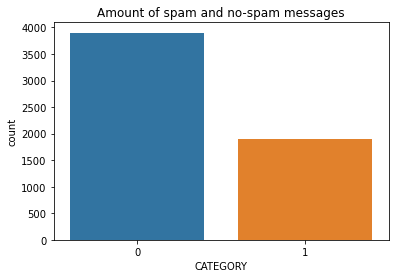

In [209]:
sns.countplot(data = data, x= data['CATEGORY']).set_title("Amount of spam and no-spam messages")
plt.show()

In [210]:
spam_df = data[data['CATEGORY'] == SPAM_CAT] #create sub-dataframe of spam text
ham_df = data[data['CATEGORY'] == HAM_CAT] #sub-dataframe of ham text

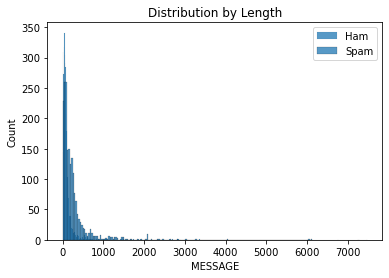

In [211]:
ham =data[data['CATEGORY'] == HAM_CAT]['MESSAGE'].str.len()
sns.histplot(ham, label='Ham')
spam = data[data['CATEGORY'] == SPAM_CAT]['MESSAGE'].str.len()
sns.histplot(spam, label='Spam')
plt.title('Distribution by Length')
plt.legend()

plt.savefig('Distrbution of word by length.png')

In [212]:
data.MESSAGE

Doc_ID
0       [dear, homeowner, interest, rates, lowest, poi...
1       [attention, this, must, all, computer, users, ...
2       [this, message, mime, format, we, dare, try, b...
3       [important, information, the, new, domain, nam...
4       [this, line, if, give, away, cd, free, people,...
                              ...                        
5791    [i, working, week, tes, updates, servers, sync...
5792    [damien, morton, quoted, approves, html, now, ...
5793    [on, mon, che, wrote, thats, correct, lines, a...
5794    [once, time, manfred, wrote, i, like, install,...
5795    [if, run, pick, use, new, ftoc, button, messag...
Name: MESSAGE, Length: 5796, dtype: object

In [215]:
#for counting frequently occurence of spam and ham.
from collections import Counter

ham_MESSAGE = data[data['CATEGORY'] == HAM_CAT]['MESSAGE']
ham_string = ham_MESSAGE.to_string()
split_ham_string = ham_string.split()
ham_string_counter = Counter(split_ham_string)
most_ham = ham_string_counter.most_common(30)
data1 = pd.DataFrame.from_dict(most_ham)
data1 = data1.rename(columns={0: "words of ham", 1 : "count_"})


spam_MESSAGE = data[data['CATEGORY'] == SPAM_CAT]['MESSAGE']
spam_string = spam_MESSAGE.to_string()
split_spam_string = spam_string.split()
spam_string_counter = Counter(split_spam_string)
most_spam = spam_string_counter.most_common(30)
data2 = pd.DataFrame.from_dict(most_spam)
data2 = data2.rename(columns={0: "words of spam", 1 : "count_"})

print(most_ham)

[('wrote,', 898), ('i,', 877), ('date,', 686), ('[on,', 639), ('[url,', 624), ('...', 511), ('aug,', 265), ('not,', 223), ('[i,', 215), ('sep,', 211), ('supplied,', 203), ('message,', 160), ('on,', 157), ('the,', 156), ('jul,', 156), ('wed,', 152), ('tue,', 145), ('mon,', 139), ('time,', 138), ('writes,', 128), ('[hi,', 126), ('from,', 123), ('thu,', 119), ('fri,', 117), ('in,', 98), ('said,', 94), ('matthias,', 93), ('[once,', 92), ('perl,', 82), ('[this,', 82)]


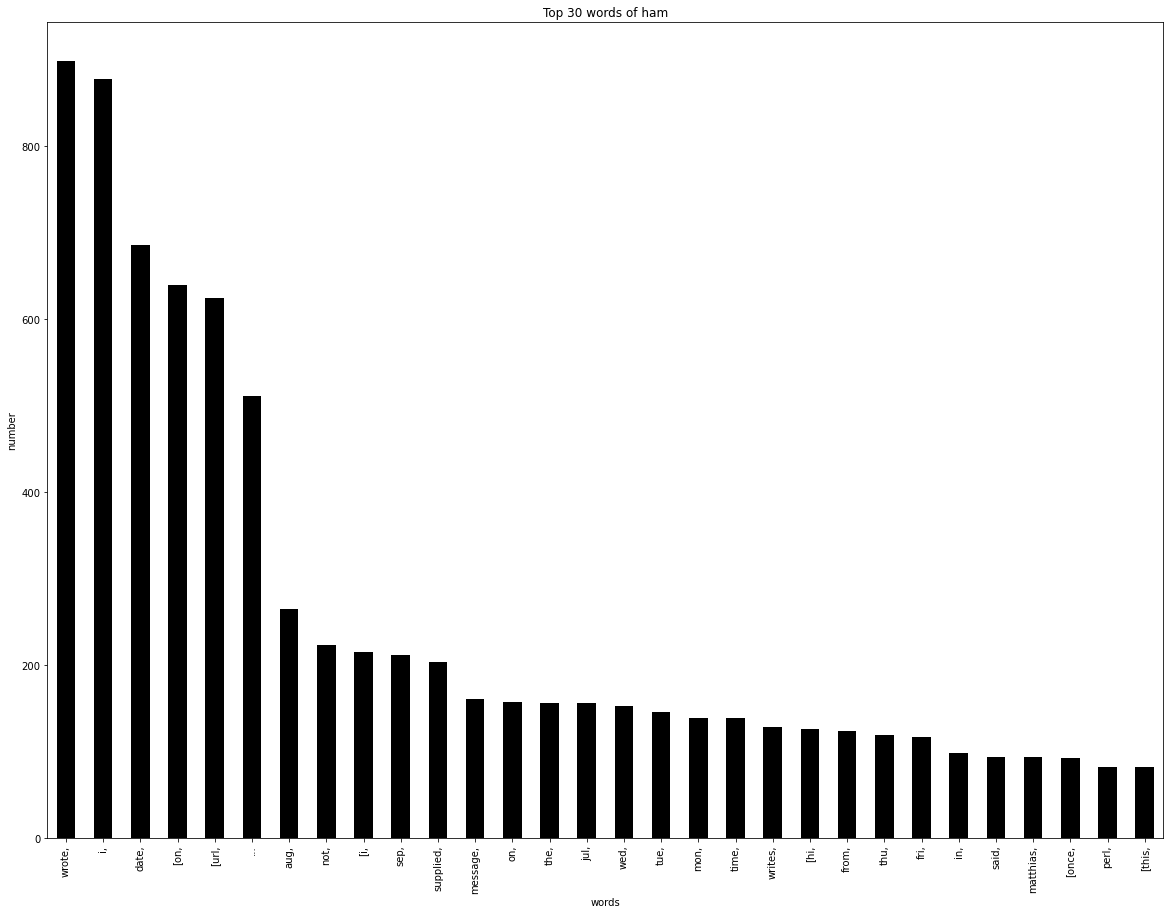

<Figure size 432x288 with 0 Axes>

In [216]:
data1.plot.bar(legend = False, color = 'black',figsize = (20,15))
y_pos = np.arange(len(data1["words of ham"]))
plt.xticks(y_pos, data1["words of ham"])
plt.title('Top 30 words of ham')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

plt.savefig('Top30 words ham.png',dpi=199)

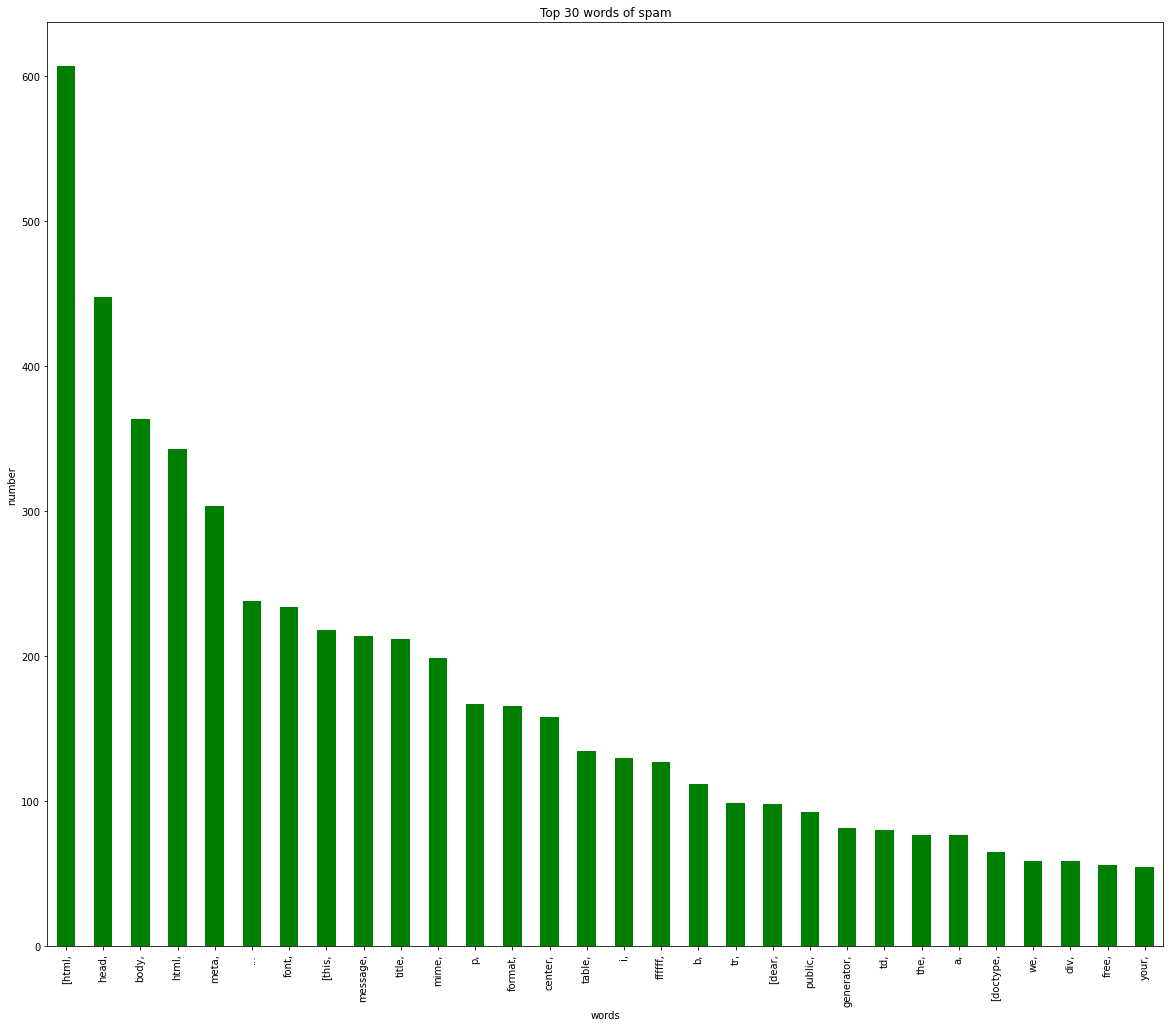

In [217]:
data2.plot.bar(legend = False, color = 'green', figsize = (20,17))
y_pos = np.arange(len(data2["words of spam"]))
plt.xticks(y_pos, data2["words of spam"])
plt.title('Top 30 words of spam')
plt.xlabel('words')
plt.ylabel('number')
plt.show()